## **Set up**

In [ ]:
from google.colab import files
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

from imutils import paths
import random
import pickle
import cv2
import csv
import os

# Install Kaggle library
!pip install -q kaggle


In [ ]:
# Upload kaggle API key file
uploaded = files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/


In [ ]:
!kaggle datasets download -d jessicali9530/stanford-cars-dataset

In [ ]:
!unzip stanford-cars-dataset

In [ ]:
train_imagePaths = sorted(list(paths.list_images("cars_train/")))
test_imagePaths = sorted(list(paths.list_images("cars_test/")))

## **Helper Functions**

In [ ]:
def format_images(image_set, image_paths, info):
  for i in range(len(image_paths)):
    if i % 1000 == 0:
      print(i)
    imagePath = image_paths[i]
	  # load the image, resize the image to be 32x32 pixels (ignoring
	  # aspect ratio), flatten the image into 32x32x3=3072 pixel image
	  # into a list, and store the image in the data list
    image = cv2.imread(imagePath)
    row = info[i]
    x1 = int(row[0])
    x2 = int(row[2])
    y1 = int(row[1])
    y2 = int(row[3])
    image = image[y1:y2,x1:x2,:]
    image = cv2.resize(image, (300, 300))
    image_set.append(image)
  image_set = np.asarray(image_set)

def format_labels(annos, years, makes):
  info = []
  labels = []
  year_labels = []
  make_labels = []
  with open(annos) as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    count = 2
    for row in reader: # each row is a list
        if count % 3 == 0:
          info.append(row)
        count += 1

  index = 0
  count = 0
  for row in info:
    val = int(info[index][4])
    labels.append(val)
    year_labels.append(years[val-1])
    make_labels.append(makes[val-1])
    index += 1
    count += 1

  labels = np.asarray(labels)
  return info, labels, year_labels, make_labels

def format_labels_test():
  info = []

  with open('cars_test_annos.csv') as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    count = 2
    for row in reader: # each row is a list
        if count % 3 == 0:
          info.append(row)
        count += 1
  return info

def get_class_info():
  meta_data = []
  years = []
  makes = []
  with open("cars_meta.csv") as csvfile:
    reader = csv.reader(csvfile) # change contents to floats
    count= 1
    for row in reader: # each row is a list
      if count != 1:
        meta_data.append(row)
      count += 1
  class_names = meta_data[0]

  for name in class_names:
    split = name.split()
    year = split[len(split) - 1]
    years.append(int(year))
    makes.append(split[0])
  return class_names, years, makes

def removeDuplicates(nums):
  """
  :type nums: List[int]
  :rtype: int
  """
  a = nums[:]
  i = 0
  while i < len(a) - 1:
    j = i + 1
    while j < len(a):
      if a[j] == a[i]:
        a.remove(a[i])
      else:
        i += 1
        break
            
  return a             

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True

## **Formatting Data & Labels for Train and Test Sets**

In [ ]:
class_names, class_years, class_makes = get_class_info()
train_info, train_classes, train_years, train_makes = format_labels("cars_train_annos.csv", class_years, class_makes)
test_info = format_labels_test()

In [ ]:
train_images = []
test_images = []
format_images(train_images, train_imagePaths, train_info)
format_images(test_images, test_imagePaths, test_info)
train_images = np.asarray(train_images)
test_images = np.asarray(test_images)

In [ ]:
make_classes = removeDuplicates(class_makes)

In [ ]:
make_classes

Creating labels (0-5) for nationality of car make

In [ ]:

make_country_classes = [0, 1, 4, 2, 2, 4, 4, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0, 4, 0, 1, 1, 1, 1, 4, 0, 3, 0, 0, 4, 2, 1, 0, 2, 1, 1, 0, 2, 0, 4, 0, 4, 1, 0, 1, 2, 4, 2]
# American = 0
# Japanese = 1
# German = 2
# Italian = 3
# Other = 4
make_country_train_labels = []
for make in train_makes:
   make_country_train_labels.append(make_country_classes[make_classes.index(make)])
make_country_train_labels_one_hot = keras.utils.to_categorical(make_country_train_labels)

Creating labels (0-49) for specific car makes


In [ ]:
make_train_labels_makes = []
for make in train_makes:
  make_train_labels_makes.append(make_classes.index(make))
make_train_labels_makes_onehot = keras.utils.to_categorical(make_train_labels_makes)


**make_country_train_labels_one_hot** now contains the one-hot vector format of the nationality of each training example

**train_makes** contains the specific string version of each make in the training set

## **Defining the models**
## Model 1: CNN to classify which nationality the car's manufacturer resides in

In [ ]:
nation_model = keras.Sequential()
nation_model.add(keras.layers.Conv2D(16, (3,3),activation='relu',input_shape=(300,300,3)))
nation_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
nation_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
nation_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# nation_model.add(keras.layers.Conv2D(64, (3,3),activation='relu'))
# nation_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# nation_model.add(keras.layers.Conv2D(45, (2,2),activation='relu'))
# nation_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#nation_model.add(keras.layers.Dropout(0.2))
nation_model.add(keras.layers.Flatten())
nation_model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
nation_model.add(keras.layers.Dense(5, activation='softmax'))

In [ ]:
nation_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
nation_history = nation_model.fit(train_images, make_country_train_labels_one_hot, epochs = 30, batch_size = 100)

<Figure size 432x288 with 0 Axes>

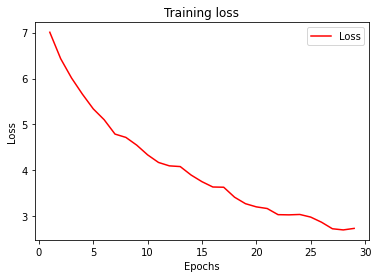

<Figure size 432x288 with 0 Axes>

In [ ]:
loss=nation_history.history['loss']
zoomed_loss = loss[1:]
epochs=range(len(loss))[1:]
plt.plot(epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

## Model 2: CNN to classify specifically which manufacturer made the car in the image

In [ ]:
make_model = keras.Sequential()
make_model.add(keras.layers.Conv2D(16, (3,3),activation='relu',input_shape=(300,300,3)))
make_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
make_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
make_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
make_model.add(keras.layers.Conv2D(64, (3,3),activation='relu'))
make_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# make_model.add(keras.layers.Conv2D(45, (2,2),activation='relu'))
# make_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#make_model.add(keras.layers.Dropout(0.2))
make_model.add(keras.layers.Flatten())
make_model.add(keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer='l2'))
make_model.add(keras.layers.Dense(49, activation='softmax'))

callbacks = myCallback()

In [ ]:
make_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
make_history = make_model.fit(train_images, make_train_labels_makes_onehot, epochs = 50, batch_size = 100, callbacks = [callbacks])

<Figure size 432x288 with 0 Axes>

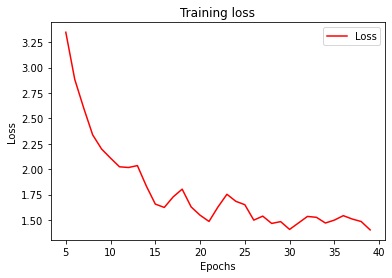

<Figure size 432x288 with 0 Axes>

In [ ]:
loss=make_history.history['loss']
zoomed_loss = loss[5:]
epochs=range(len(loss))[5:]
plt.plot(epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

## Testing classifiers on random images from test set

['BMW']


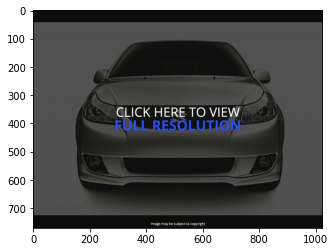

In [ ]:
indexes = []
samples = []
full_images = []
for i in range(1):
  idx = np.random.choice(range(len(test_images)))
  indexes.append(idx)
  samples.append(test_images[idx])
  full_images.append(cv2.imread(test_imagePaths[idx]))

samples = np.array(samples)
predictions = make_model.predict(x=samples)
make_preds = np.argmax(predictions,axis=1)

for image in full_images:
  plt.imshow(image)

finals = [make_classes[pred] for pred in make_preds]
print(finals)

